<a href="https://colab.research.google.com/github/Dahuginn/4yr_animerecommend/blob/main/%5BThesis%5Dgraph_split_node2vec.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install node2vec
!pip install stellargraph

In [2]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

import networkx as nx
import stellargraph as sg
from sklearn.model_selection import train_test_split
from stellargraph.data import EdgeSplitter
from sklearn.manifold import TSNE

from node2vec import Node2Vec

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import PredefinedSplit
from sklearn import svm
from sklearn.linear_model import LogisticRegressionCV, RidgeClassifierCV

from sklearn.metrics import roc_auc_score, roc_curve, auc, f1_score, precision_recall_curve, precision_score, recall_score
from sklearn.model_selection import validation_curve, learning_curve

from google.colab import drive
drive.mount('/content/gdrive')
import sys
sys.path.append('/content/gdrive/My Drive')
import pickle

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


# Upload a graph created in the previous notebook

I decided to separate the workflow into two notebooks, because otherwise we could've overloaded colab's RAM. Creating a big df, then turning it into a graph, then training a node2vec model are memory consuming.

In [3]:
fh = open("/content/gdrive/My Drive/4 year/800graph.graphml", "rb")
graph = nx.read_graphml(fh)
nx.info(graph)

'Graph with 399 nodes and 20771 edges'

# Link prediction task

So far we've seen nice pictures of the graph we've created. But how are we going to use it to recommend animes to a user?? We need to formulate the task at hand using the language of machine learning.

We have links that exist in or graph, and we are going to sample the links that do not along with them. The former will be marked as "1", the latter - as "0". For each new pair of animes we are going to predoct whether the link between them could exist - this is the classification task. 
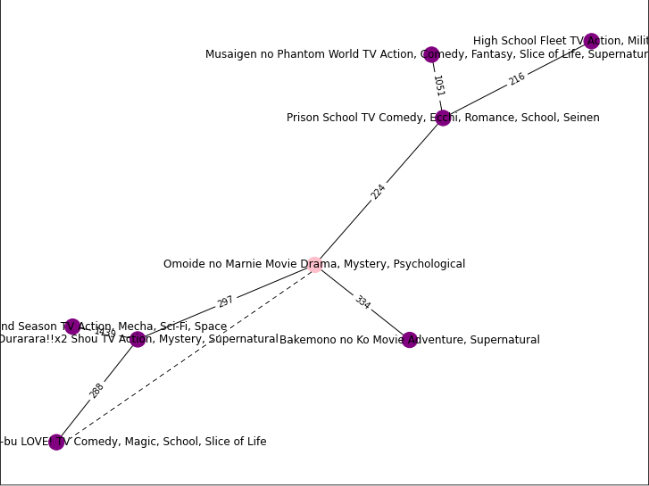

# Train-val-split

We can't just split the dataset we used for a graph as we need ro split over the connections between nodes, nod the nodes themselves. I'll use [EdgeSplitter](https://stellargraph.readthedocs.io/en/latest/_modules/stellargraph/data/edge_splitter.html) for splitting my graph. EdgeSpliier is a class from Stellargraph package that takes a graph as an input, samples a given percentage of edges to create a smaller graph. It returns ids and labels of the sampled edges. The labels mark existant and non-existant edges. EdgeSplitter randomly chooses 2 nodes (DFS from the source node) and the checks if they are connected or not - if the latter is true, the edge is labeled as 0. This process is called negative sampling. Positive sampling is conducted by first computing the minimum spanning tree - EdgeSplitter is going to remove edges from graph one by one, therefore the MST must be crossed out of the removal list. The rest of the edges are removed until we meet the needed percentage of edges for our reduced graph.

We are going to 1) sample 5% of edges from the full graph for test. 2) then sample another 5% for train graph without our test graph: 3) split edges and labels we received on the 2nd step to split 75% of edges for training purposes and another 25% will go to model selection.

In [4]:
edge_splitter_test = EdgeSplitter(graph)
graph_test, examples_test, labels_test = edge_splitter_test.train_test_split(p=0.05, method="global")

print(nx.info(graph_test))

** Sampled 1038 positive and 1038 negative edges. **
Graph with 399 nodes and 19733 edges


In [5]:
edge_splitter_train = EdgeSplitter(graph_test, graph)
graph_train, examples, labels = edge_splitter_train.train_test_split(p=0.05, method="global")
examples_train, examples_model_selection, labels_train, labels_model_selection = train_test_split(examples, labels, train_size=0.75, test_size=0.25)

print(nx.info(graph_train))

** Sampled 986 positive and 986 negative edges. **
Graph with 399 nodes and 18747 edges


In [6]:
pd.DataFrame(
    [("Training", len(examples_train), "Train classifier"),
      ("Model Selection", len(examples_model_selection), "select the best link classifier model"),
     ("Test", len(examples_test), "evaluate the classifier")],
     columns=("Split", "Num ", "Purpose")).set_index("Split")

,Num,Purpose
Split,,
Training,1479,Train classifier
Model Selection,493,select the best link classifier model
Test,2076,evaluate the classifier


# node2vec models

This will be our working model

In [ ]:
node2vec = Node2Vec(graph_train, dimensions=64, walk_length=30, num_walks=200, workers=4) 
# Embed nodes
model = node2vec.fit(window=10, min_count=1, batch_words=4)

Computing transition probabilities:   0%|          | 0/399 [00:00<?, ?it/s]

In [41]:
def plot_tsne(model):
  ne = model.wv.vectors
  tsne2 = TSNE(n_components=2, random_state=42, init='random', learning_rate=200.0)
  ne_2d = tsne2.fit_transform(ne)
  plt.scatter(ne_2d[:, 0], ne_2d[:, 1])
  plt.show()

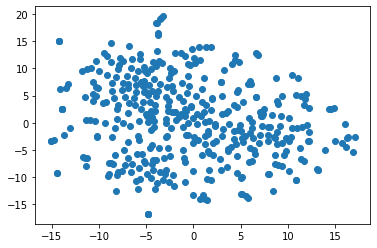

In [42]:
plot_tsne(model)

# node2vec: find similar titles

Here we can already make some predictions looking at the most similar vectors, even without creating a model:

In [7]:
nodes = []
for i in graph.nodes():
  nodes.append(i)

In [8]:
names_available = np.unique(nodes)

In [12]:
print(names_available[28], model.wv.get_vector(names_available[28]))

Bakuten Shoot Beyblade TV Action, Adventure, Comedy, Sci-Fi, Shounen, Sports [-0.00188487  0.06963326  0.08188592  0.14084136  0.0778932  -0.05797881
 -0.18040024  0.08901634  0.03213757 -0.07691123  0.02469066 -0.08986938
  0.03252469  0.06467438 -0.12471996 -0.01629433 -0.08107644 -0.05317818
 -0.1047781  -0.176179   -0.06271743 -0.06215132 -0.01922776  0.32061285
  0.1254777   0.1300684   0.08387738 -0.03016634  0.11390702 -0.12308861
  0.21327184  0.04099601  0.11198536 -0.00329359 -0.19790319  0.06972747
  0.16020498 -0.02462047  0.15488736 -0.29205936 -0.1607902   0.1472005
  0.02473505 -0.13026063  0.07270297 -0.19131896  0.25719115 -0.10770362
  0.00760251  0.2012373   0.04456044  0.20888756  0.15533844  0.01949562
 -0.3787972   0.08652775  0.01784316  0.05466971 -0.05197539 -0.0301387
  0.13030852  0.07867821 -0.07663938  0.0754538 ]


In [13]:
# cute anmes for nostalgic mood
for node, score in model.wv.most_similar('Bakuten Shoot Beyblade TV Action, Adventure, Comedy, Sci-Fi, Shounen, Sports'):
  print(node, score)

Shaman King TV Action, Adventure, Comedy, Drama, Shounen, Supernatural 0.688073992729187
One Piece Film: Strong World Episode 0 OVA Action, Adventure, Comedy, Fantasy, Shounen, Super Power 0.6509325504302979
Pokemon Diamond &amp; Pearl: Dialga vs. Palkia vs. Darkrai Movie Action, Adventure, Comedy, Drama, Fantasy, Kids 0.6108652949333191
Dragon Ball Z Movie 01: Ora no Gohan wo Kaese!! Movie Adventure, Comedy, Fantasy, Sci-Fi, Shounen 0.601933479309082
Dragon Ball Movie 2: Majinjou no Nemuri Hime Movie Action, Adventure, Comedy, Fantasy, Sci-Fi, Shounen, Super Power 0.5812923908233643
Naruto Soyokazeden Movie: Naruto to Mashin to Mitsu no Onegai Dattebayo!! Movie Action, Comedy, Martial Arts, Shounen, Super Power 0.5761497020721436
One Piece: Straw Hat Theater Special Adventure, Fantasy, Shounen 0.5738396644592285
Zoids TV Action, Adventure, Comedy, Mecha, Sci-Fi 0.5670552849769592
Naruto: Shippuuden Movie 3 - Hi no Ishi wo Tsugu Mono Movie Action, Comedy, Martial Arts, Shounen, Super P

# Classification

In [15]:
def operator_hadamard(u, v):
    return u * v


def operator_l1(u, v):
    return np.abs(u - v)


def operator_l2(u, v):
    return (u - v) ** 2


def operator_avg(u, v): 
    return (u + v) / 2.0

In [16]:
def get_vectorized(link_features, model):
  s = []
  d = []
  for src, dst in link_features:
    s.append(model.wv[src])
    d.append(model.wv[dst])
  return np.array(s), np.array(d)

In [17]:
def apply_operator(s, d, op):
  transformed = op(s, d)
  return transformed

In [18]:
binary_operators = [operator_hadamard, operator_l1, operator_l2, operator_avg]

In [19]:
def do_classification(f_train, l_train, op, model):
  s, d = get_vectorized(f_train, model)
  X_train = op(s, d)
  y_train = l_train

  lr_clf = LogisticRegressionCV(Cs=np.logspace(0.01, 1, 5), cv=10, scoring="f1", max_iter=1000)
  pipa = Pipeline(steps=[("sc", StandardScaler()), ("clf", lr_clf)])
  pipa.fit(X_train, y_train)

  return pipa

In [20]:
def evaluate(classif, f_test, l_test, op, model):
  s_test, d_test = get_vectorized(f_test, model)
  testing_labels = apply_operator(s_test, d_test, op)
  predicted = classif.predict_proba(testing_labels)
  predictedf1 = classif.predict(testing_labels)
  positive_column = list(classif.classes_).index(1)
  return f1_score(l_test, predictedf1)

In [21]:
def run_prediction(op, model):
  clf = do_classification(examples_train, labels_train, op, model)
  score = evaluate(clf, examples_model_selection, labels_model_selection, op, model)
  return {
        "classifier": clf,
        "binary_operator": op,
        "score": score
    }

In [22]:
def show_best_op(model):
  results = [run_prediction(op, model) for op in binary_operators]
  best_result = max(results, key=lambda result: result["score"])

  print(f"Best result from '{best_result['binary_operator'].__name__}'")

  return pd.DataFrame(
      [(result["binary_operator"].__name__, result["score"]) for result in results],
      columns=("name", "f1 score"),
  ).set_index("name"), best_result

In [23]:
res, best_result = show_best_op(model)
res

Best result from 'operator_avg'


,f1 score
name,
operator_hadamard,0.780952
operator_l1,0.732000
operator_l2,0.766859
operator_avg,0.843137


# Evaluation

## Get embeddings

In [ ]:
node2vec_test = Node2Vec(graph_test, dimensions=64, walk_length=30, num_walks=200, workers=4) 
model_test = node2vec_test.fit(window=10, min_count=1, batch_words=4)

Computing transition probabilities:   0%|          | 0/399 [00:00<?, ?it/s]

In [42]:
s_train, d_train = get_vectorized(examples, model)
s_test, d_test = get_vectorized(examples_test, model)
X_train = best_result["binary_operator"](s_train, d_train)
X_test = best_result["binary_operator"](s_test, d_test)
y_train = labels
y_test = labels_test

lr_clf = LogisticRegressionCV(Cs=np.logspace(0.01, 1, 5), scoring="roc_auc", max_iter=1000)
pipa = Pipeline(steps=[("sc", StandardScaler()), ("clf", lr_clf)])
pipa.fit(X_train, y_train)

Pipeline(steps=[('sc', StandardScaler()),
                ('clf',
                 LogisticRegressionCV(Cs=array([ 1.02329299,  1.80925591,  3.19889511,  5.65587757, 10.        ]),
                                      max_iter=1000, scoring='roc_auc'))])

In [43]:
def plot_tsne_test(model, op, estimator, title, f_test):
  yhat = estimator.predict(f_test)

  tsne2 = TSNE(n_components=2, random_state=42, init='random', learning_rate=200.0)
  ne_2d = tsne2.fit_transform(f_test)

  plt.scatter(f_test[:, 0], f_test[:, 1], c=np.where(yhat == 1, "b", "r"), alpha=0.5)
  plt.show()

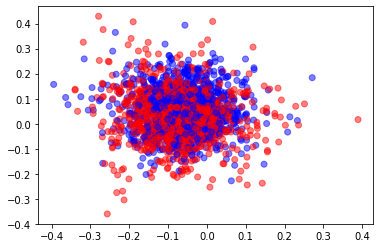

In [44]:
plot_tsne_test(lr_clf, 'Classification', X_test)

# Plot ROC-AUC curve

[Source code](https://machinelearningmastery.com/roc-curves-and-precision-recall-curves-for-classification-in-python/#:~:text=A%20precision%2Drecall%20curve%20is,constant%20class%20in%20all%20cases)

In [45]:
def plot_rocauc(model, op, estimator, title, f_train, l_train, f_test, l_test):

  #roc_auc
  ns_probs = [0 for _ in range(len(l_test))]

  lr_probs = estimator.predict_proba(f_test)
  lr_probs_ = lr_probs[:, 1]

  ns_auc = roc_auc_score(l_test, ns_probs)
  lr_auc = roc_auc_score(l_test, lr_probs_)

  # summarize scores
  print('No Skill: ROC AUC=%.3f' % (ns_auc))
  print('Logistic: ROC AUC=%.3f' % (lr_auc))

  # calculate roc curves
  ns_fpr, ns_tpr, _ = roc_curve(l_test, ns_probs)
  lr_fpr, lr_tpr, _ = roc_curve(l_test, lr_probs_)

  # plot the roc curve for the model
  plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
  plt.plot(lr_fpr, lr_tpr, marker='.', label='Logistic')

  # axis labels
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title(title)

  # show the legend
  plt.legend()

  # show the plot
  plt.show()

ROC-AUC curve defines how good (or how bad) our model is at distinguishing classes. However, it will give us overly optimistic scores even if our model classifies everything as 1 or as 0. We'll need to use different metrics.

No Skill: ROC AUC=0.500
Logistic: ROC AUC=0.953


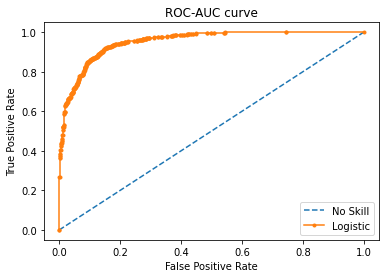

In [46]:
plot_rocauc(pipa, 'ROC-AUC curve', X_train, y_train, X_test, y_test)

# Plot Precision-Recall curve

[Source code](https://machinelearningmastery.com/roc-curves-and-precision-recall-curves-for-classification-in-python/)

In [47]:
def plot_prc(model, op, estimator, title, f_train, l_train, f_test, l_test):
  ns_probs = [0 for _ in range(len(l_test))]

  lr_probs = estimator.predict_proba(f_test)
  lr_probs_ = lr_probs[:, 1]

  # predict class values
  yhat = estimator.predict(f_test)
  lr_precision, lr_recall, _ = precision_recall_curve(l_test, lr_probs_)
  lr_f1, lr_auc, lr_pr, lr_rec = f1_score(l_test, yhat), auc(lr_recall, lr_precision), precision_score(y_test, yhat), recall_score(y_test, yhat)

  # summarize scores
  print('Logistic: f1=%.3f auc=%.3f precision=%.3f recall=%.3f' % (lr_f1, lr_auc, lr_pr, lr_rec))

  # plot the precision-recall curves
  no_skill = len(l_test[l_test==1]) / len(l_test)

  plt.figure(figsize=(10, 8))
  plt.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')
  plt.plot(lr_recall, lr_precision, marker='.', label='Logistic')

  # axis labels
  plt.xlabel('Recall')
  plt.ylabel('Precision')
  plt.title(title)

  # show the legend
  plt.legend()

  # show the plot
  plt.show()

Precision computes the number of the observations we predicted to be 1 and are, actually, to all the 1-s we predicted. Precision score of 0.874 means there is a quite small number of negatives we've labeled as positives - but it's all good!
Recall score shows us what percentage of real positives we've labelled as such. 0.888 - means that we've labeled some 1-s as 0-s - still all good!
F1 score is a weighted average of precision and recall, it considers both types of our mistakes - FP and FN - into account.

Logistic: f1=0.881 auc=0.952 precision=0.874 recall=0.888


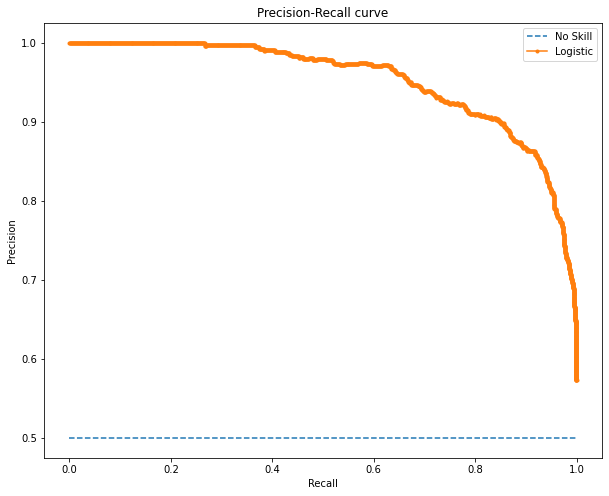

In [48]:
plot_prc(pipa, 'Precision-Recall curve', X_train, y_train, X_test, y_test)

# Plot learning curves

The scores are pretty good, but what if the model is overfitted? We can check the learning curves:

[Source code](https://scikit-learn.org/stable/auto_examples/model_selection/plot_learning_curve.html)

In [49]:
def plot_learning_curve(
    estimator,
    title,
    X,
    y,
    axes=None,
    ylim=None,
    cv=None,
    n_jobs=None,
    train_sizes=np.linspace(0.1, 1.0, 5)):

    if axes is None:
        _, axes = plt.subplots(1, 3, figsize=(20, 5))

    axes[0].set_title(title)
    if ylim is not None:
        axes[0].set_ylim(*ylim)
    axes[0].set_xlabel("Training examples")
    axes[0].set_ylabel("Score")

    train_sizes, train_scores, test_scores, fit_times, _ = learning_curve(
        estimator,
        X,
        y,
        cv=cv,
        n_jobs=n_jobs,
        train_sizes=train_sizes,
        return_times=True,
    )
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    fit_times_mean = np.mean(fit_times, axis=1)
    fit_times_std = np.std(fit_times, axis=1)

    # Plot learning curve
    axes[0].grid()
    axes[0].fill_between(
        train_sizes,
        train_scores_mean - train_scores_std,
        train_scores_mean + train_scores_std,
        alpha=0.1,
        color="r",
    )
    axes[0].fill_between(
        train_sizes,
        test_scores_mean - test_scores_std,
        test_scores_mean + test_scores_std,
        alpha=0.1,
        color="g",
    )
    axes[0].plot(
        train_sizes, train_scores_mean, "o-", color="r", label="Training score"
    )
    axes[0].plot(
        train_sizes, test_scores_mean, "o-", color="g", label="Cross-validation score"
    )
    axes[0].legend(loc="best")

    # Plot n_samples vs fit_times
    axes[1].grid()
    axes[1].plot(train_sizes, fit_times_mean, "o-")
    axes[1].fill_between(
        train_sizes,
        fit_times_mean - fit_times_std,
        fit_times_mean + fit_times_std,
        alpha=0.1,
    )
    axes[1].set_xlabel("Training examples")
    axes[1].set_ylabel("fit_times")
    axes[1].set_title("Scalability of the model")

    # Plot fit_time vs score
    fit_time_argsort = fit_times_mean.argsort()
    fit_time_sorted = fit_times_mean[fit_time_argsort]
    test_scores_mean_sorted = test_scores_mean[fit_time_argsort]
    test_scores_std_sorted = test_scores_std[fit_time_argsort]
    axes[2].grid()
    axes[2].plot(fit_time_sorted, test_scores_mean_sorted, "o-")
    axes[2].fill_between(
        fit_time_sorted,
        test_scores_mean_sorted - test_scores_std_sorted,
        test_scores_mean_sorted + test_scores_std_sorted,
        alpha=0.1,
    )
    axes[2].set_xlabel("fit_times")
    axes[2].set_ylabel("Score")
    axes[2].set_title("Performance of the model")

    return plt

There's a small gap between val score and training score, after the 120th example both plots go stable. Perfomance of the model goes down, but it's still quite high. 

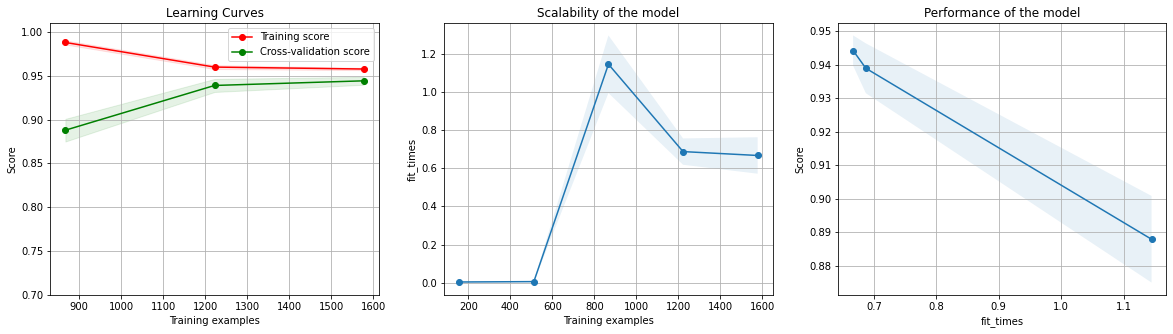

In [50]:
title = "Learning Curves"
plot_learning_curve(pipa, title, X_train, y_train, ylim=(0.7, 1.01), n_jobs=4)
plt.show()

# Dump'n'Load

Train

In [ ]:
pickle.dump(model, open('/content/gdrive/My Drive/4 year/final_node2vec_800.sav', 'wb'))

In [10]:
model = pickle.load(open('/content/gdrive/My Drive/4 year/final_node2vec_800.sav', 'rb'))

Test

In [ ]:
pickle.dump(model_test, open('/content/gdrive/My Drive/4 year/final_node2vec_test800.sav', 'wb'))

In [11]:
model_test = pickle.load(open('/content/gdrive/My Drive/4 year/final_node2vec_test800.sav', 'rb'))